In [55]:
using Rays

# A view of a cube

### The basic setup

In [56]:
# Define the scene
scene = Rays.Scene()

# Define a camera
camera = Rays.Camera(; screen_res = (500, 500))
push!(scene, camera)

# Define a cube at the origin
cube = Rays.Cube(1.0f0)
push!(scene, cube)

# Show scene information
display(scene)

# Let the camera look towards the origin
from = Float32[2.0, 2.0, 2.0]
to = zeros(Float32, 3)
Rays.look_at!(camera, from, to)

# Set how shape brightness drops of with distance to the camera
# in a default way based on the shapes in the scene relative to the camera.
camera = Rays.set_dropoff_curve_default!(scene, camera)

# Compute ray intersections with the cube
Rays.render!(scene)

Rays.Scene{Float32, Matrix{Float32}, Matrix{Int64}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}
* Cameras:
	<Camera 'camera'>

* Shapes:
	<Cube 'cube'>

* Transforms:
	cube: <AffineTransform; identity>

* Textures:
	cube: <UniformTexture; color = Float32[1.0, 1.0, 1.0]>


### Viewing the canvas

In [57]:
using Images: colorview, RGB, N0f8

function view_canvas(camera)
    canvas_RGB = RGB{N0f8}.([view(camera.canvas, channel, :, :) for channel = 1:3]...)
    colorview(RGB, canvas_RGB)
end

view_canvas (generic function with 1 method)

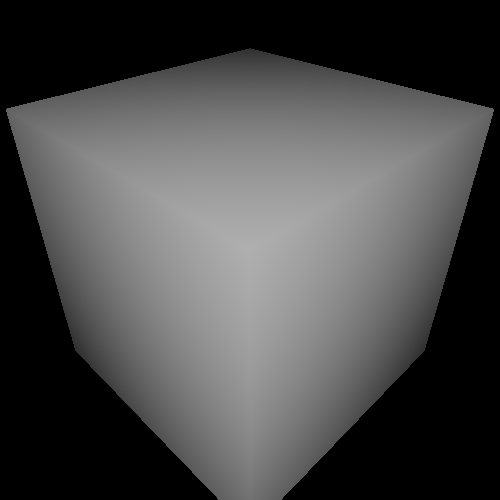

In [58]:
view_canvas(camera)

### Adding depth of field

In [59]:
# This curve determines how the blurring depends on the distance to
# the camera
focus_curve(t) = 0.5 + 10 * abs(t - 3)
camera = Rays.set_focus_curve(camera, focus_curve)
push!(scene, camera; replace = true)

Rays.render!(scene)

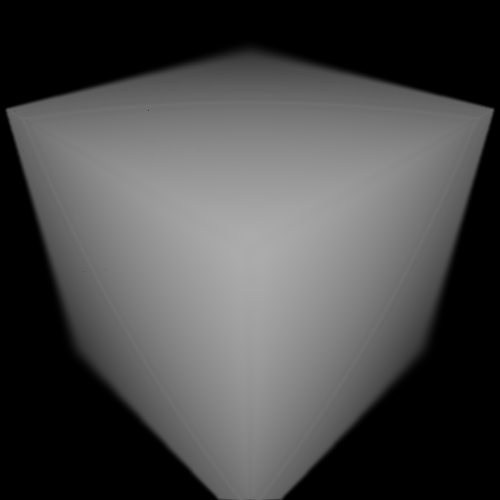

In [60]:
view_canvas(camera)

### Replace the cube by a Menger sponge

In [61]:
menger_sponge = Rays.menger_sponge(1.0f0, 3)
Rays.clear_shapes!(scene)
push!(scene, menger_sponge)

Rays.render!(scene)

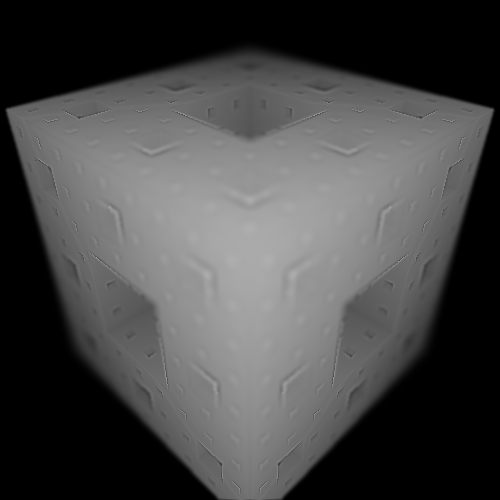

In [62]:
view_canvas(camera)

### Add a camera warp

In [63]:
using Accessors: @set

# Define warp function and assign it to the camera
function warp!(v)::Nothing
    v[3] = v[3] + 0.1 * sin(250 * v[2])
    v[1] = v[1] + 0.1 * sin(250 * v[2])
    return nothing
end

camera_warped = Rays.set_warp(camera, warp!)
camera_warped = @set camera_warped.name = :camera_warped

push!(scene, camera_warped)

Rays.render!(scene; name_camera = :camera_warped)

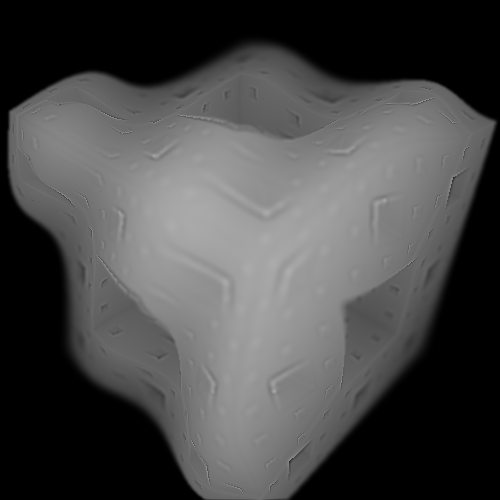

In [64]:
view_canvas(camera_warped)

# Available shapes

### Default

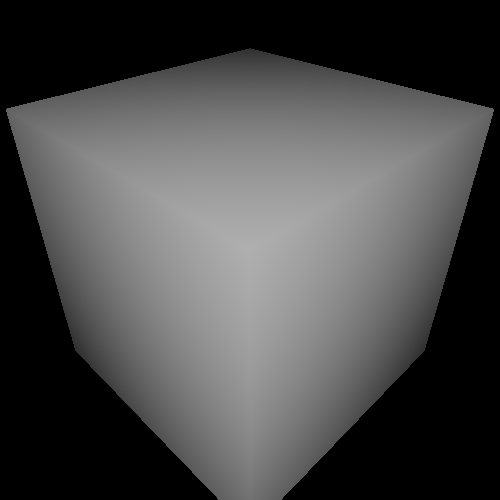

<Cube 'cube'>


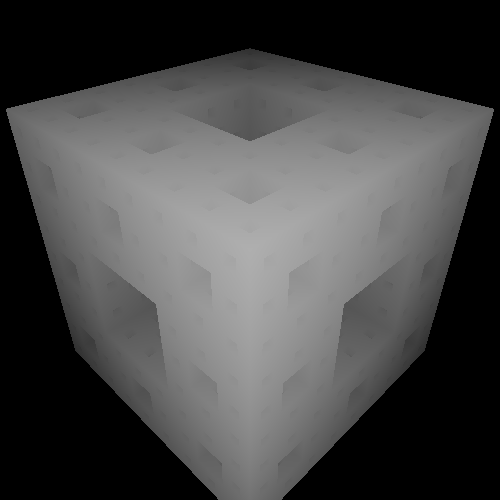

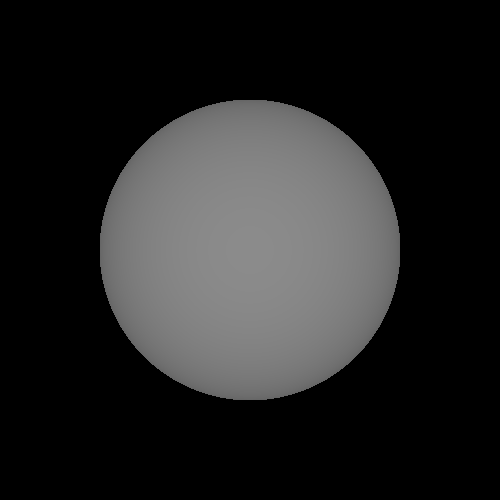

<FractalShape 'menger_sponge'; 20 subshapes of <Cube 'cube'>>
<Sphere 'sphere'>

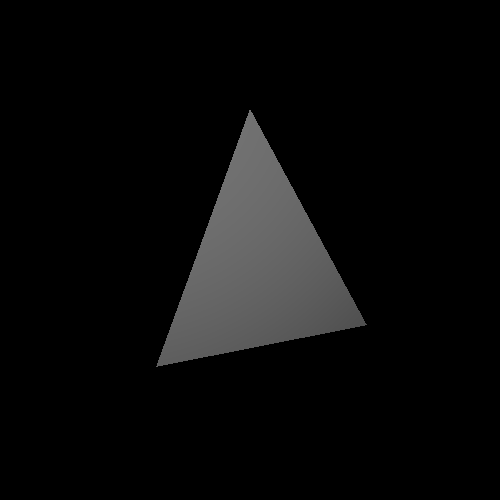

<TriangleShape 'tetrahedron'; with 4 vertices and 4 faces>


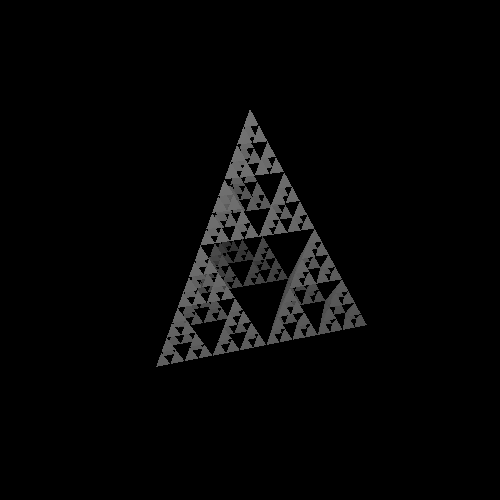

<FractalShape 'sierpinski_pyramid'; 4 subshapes of <TriangleShape 'tetrahedron'; with 4 vertices and 4 faces>>


In [65]:
scene.cameras[:camera] = @set camera.focus_curve = nothing
R = 1.0f0


shapes = [
    Rays.Cube(R),
    Rays.menger_sponge(R, 3),
    Rays.Sphere(R),
    Rays.Tetrahedron(R),
    Rays.sierpinski_pyramid(R, 4)
]

function simple_view!(shape)
    Rays.clear_shapes!(scene)
    push!(scene, shape)
    Rays.render!(scene; name_camera = :camera)
    println(shape)
    display(view_canvas(camera))
end

for shape in shapes
    simple_view!(shape)
end
    

### Custom

Implicit surface

In [66]:
"""
The 0-set of this function is an equipotential surface for 4 point sources.
"""
function my_field(loc::Vector{F})::F where {F}
	x, y, z = loc
	out = -4.0f0
	for i in 0:3
		θ = convert(F, π * (i / 2 + 0.33))
		out += one(F) / sqrt((x - cos(θ))^2 + (y - sin(θ))^2 + z^2)
	end
	return out
end

my_field

In [67]:
equipotential_surface =
	Rays.ImplicitSurface(
		my_field; 
		R_bound = 1.5f0, 
		n_divisions = 50, 
		tol = 1.0f-5, 
		itermax = 10,
		name = :equipotential_surface)

simple_view!(equipotential_surface)

MethodError: MethodError: no method matching (FunctionWrappers.FunctionWrapper{Float32, Tuple{SubArray{Float32, 1, MF, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}} where MF<:AbstractMatrix{Float32})(::typeof(my_field))

Surface of revolution

In [68]:
stand = Rays.RevolutionSurface(
	z -> z^2 + 0.1f0,
	3.0f0,
	-1.0f0,
	0.75f0;
	n_divisions = 50,
)

simple_view!(stand)

CompositeException: TaskFailedException

    nested task error: MethodError: no method matching _intersect_ray!(::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ::SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ::Rays.RevolutionSurface{Float32, Nothing})
    
    Closest candidates are:
      _intersect_ray!(::AbstractVector{F}, ::AbstractVector{Int64}, ::AbstractVector{F}, ::AbstractVector{F}, ::AbstractVector{F}, !Matched::Rays.Sphere{F}) where F
       @ Rays c:\Users\bart1\Documents\Julia_projects\Rays\core\src\intersection.jl:110
      _intersect_ray!(::AbstractVector{F}, ::AbstractVector{Int64}, ::AbstractVector{F}, ::AbstractVector{F}, ::AbstractVector{F}, !Matched::Rays.Cube{F}) where F
       @ Rays c:\Users\bart1\Documents\Julia_projects\Rays\core\src\intersection.jl:137
      _intersect_ray!(::AbstractVector{F}, ::AbstractVector{Int64}, ::AbstractVector{F}, ::AbstractVector{F}, ::AbstractVector{F}, !Matched::Rays.FractalShape{F, S, T}; current_depth, vec_temp) where {F, S, T}
       @ Rays c:\Users\bart1\Documents\Julia_projects\Rays\core\src\intersection.jl:205
      ...
    
    Stacktrace:
     [1] (::Rays.var"#24#25"{Rays.RevolutionSurface{Float32, Nothing}, Rays.AffineTransform{Float32, Missing, Missing, Missing}})(t::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ray_loc::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ray_dir::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ray_camera_loc::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ray_camera_dir::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, cache_int::SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, cache_float::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, name_intersected::SubArray{Symbol, 1, Matrix{Symbol}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true})
       @ Rays c:\Users\bart1\Documents\Julia_projects\Rays\core\src\scene.jl:165
     [2] (::FunctionWrappers.CallWrapper{Nothing})(f::Rays.var"#24#25"{Rays.RevolutionSurface{Float32, Nothing}, Rays.AffineTransform{Float32, Missing, Missing, Missing}}, arg1::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg2::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg3::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg4::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg5::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg6::SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg7::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg8::SubArray{Symbol, 1, Matrix{Symbol}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true})
       @ FunctionWrappers C:\Users\bart1\.julia\packages\FunctionWrappers\Q5cBx\src\FunctionWrappers.jl:65
     [3] macro expansion
       @ C:\Users\bart1\.julia\packages\FunctionWrappers\Q5cBx\src\FunctionWrappers.jl:137 [inlined]
     [4] do_ccall
       @ C:\Users\bart1\.julia\packages\FunctionWrappers\Q5cBx\src\FunctionWrappers.jl:125 [inlined]
     [5] FunctionWrapper
       @ C:\Users\bart1\.julia\packages\FunctionWrappers\Q5cBx\src\FunctionWrappers.jl:144 [inlined]
     [6] macro expansion
       @ c:\Users\bart1\Documents\Julia_projects\Rays\core\src\render.jl:199 [inlined]
     [7] (::Rays.var"#172#threadsfor_fun#37"{Rays.var"#172#threadsfor_fun#36#38"{Float32, Bool, Int64, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, Int64, Matrix{Float32}, Rays.Intersection{Float32, Matrix{Float32}, Matrix{Int64}}, Dict{Symbol, FunctionWrappers.FunctionWrapper{Nothing, Tuple{SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}, Dict{Symbol, FunctionWrappers.FunctionWrapper{Nothing, Tuple{SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Symbol, 1, Matrix{Symbol}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}, Rays.Camera{Float32, Nothing, Matrix{Float32}}, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
       @ Rays .\threadingconstructs.jl:200
     [8] #172#threadsfor_fun
       @ .\threadingconstructs.jl:167 [inlined]
     [9] (::Base.Threads.var"#1#2"{Rays.var"#172#threadsfor_fun#37"{Rays.var"#172#threadsfor_fun#36#38"{Float32, Bool, Int64, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, Int64, Matrix{Float32}, Rays.Intersection{Float32, Matrix{Float32}, Matrix{Int64}}, Dict{Symbol, FunctionWrappers.FunctionWrapper{Nothing, Tuple{SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}, Dict{Symbol, FunctionWrappers.FunctionWrapper{Nothing, Tuple{SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Symbol, 1, Matrix{Symbol}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}, Rays.Camera{Float32, Nothing, Matrix{Float32}}, UnitRange{Int64}}}, Int64})()
       @ Base.Threads .\threadingconstructs.jl:139

...and 11 more exceptions.


Triangle mesh

In [69]:
"""
Approximate a donut shape
"""
function Donut(R::F, r::F, n_θ::I, n_ϕ::I)::Rays.TriangleShape where {F <: AbstractFloat, I <: Integer}
    n_vertices = n_θ * n_ϕ
    n_faces = 2 * n_vertices

    Θ = range(0, 2π, n_θ + 1)[1:end-1]
    Φ = range(0, 2π, n_ϕ + 1)[1:end-1]

    vertices = zeros(F, n_vertices, 3)
    faces = zeros(I, 2 * n_θ * n_ϕ, 3)

    for (i, θ) in enumerate(Θ)
        for (j, ϕ) in enumerate(Φ) 

            vertex_idx_1 = (i - 1) * n_ϕ + j
            vertex_idx_2 = (i % n_θ) * n_ϕ + j
            vertex_idx_3 = (i - 1) * n_ϕ + j % n_ϕ + 1
            vertex_idx_4 = (i % n_θ) * n_ϕ + j % n_ϕ + 1

            vertices[vertex_idx_1, :] = [
                cos(θ) * (R + r*cos(ϕ)),
                sin(θ) * (R + r*cos(ϕ)),
                r * sin(ϕ)
            ]

            faces[vertex_idx_1, :] = [
                vertex_idx_1, 
                vertex_idx_2,
                vertex_idx_3,
            ]

            faces[n_vertices + vertex_idx_1, :] = [
                vertex_idx_4, 
                vertex_idx_2,
                vertex_idx_3,
            ]
        end
    end

    return Rays.TriangleShape(
        vertices, 
        faces, 
        name = :donut
    )
end

Donut

In [73]:
# Adjust camera
cam_donut = Rays.Camera(; screen_res = (400, 500), name = :cam_donut)
cam_donut.screen_size .= [0.08, 0.1]
Rays.look_at!(cam_donut, from, to)
push!(scene, cam_donut)

# Define donut shape
donut = Donut(1.0f0, 0.3f0, 50, 25)
Rays.clear_shapes!(scene)
push!(scene, donut)

# Set how shape brightness drops of with distance to the camera
# in a default way based on the shapes in the scene relative to the camera.
cam_donut = Rays.set_dropoff_curve_default!(scene, cam_donut)

# Generate a random color per face
face_colors = (1.0 .+ rand(3, donut.n_faces))/2
face_colors = convert(Matrix{Float32}, face_colors)
face_colors = Rays.IntegerMappingTexture(face_colors)
Rays.set_texture!(scene, :donut, face_colors)

Rays.render!(scene, name_camera = :cam_donut)

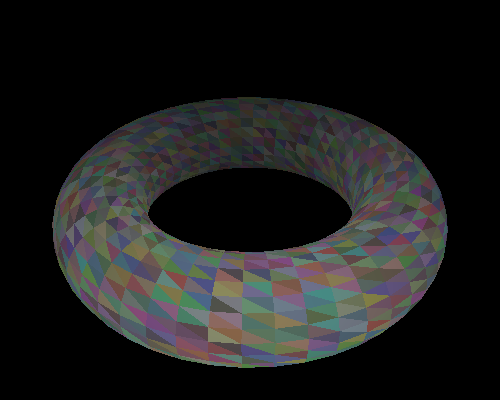

In [74]:
view_canvas(cam_donut)

# Multiple shapes

In [75]:
using Random: seed!
using LinearAlgebra: normalize, norm
seed!(314156)

# Define a texture for clarity
julia_green = Float32[0.22, 0.596, 0.149]
julia_purple = Float32[0.584, 0.345, 0.698]
julia_red = Float32[0.796, 0.235, 0.2]
julia_colors = hcat(julia_green, julia_purple, julia_red)
julia_texture = Rays.IntegerMappingTexture(julia_colors)

Rays.clear_shapes!(scene)
n_cubes = 250

for i in 1:n_cubes
    center = Float32.(1.2*(rand(3)*2 .- 1))
    R = 0.25f0/((2*norm(center))^2 + 1)
    transform = Rays.translation(center) * Rays.rotation(normalize(rand(Float32, 3)), Float32(2π)*rand(Float32))
    cube = Rays.Cube(R)
    push!(scene, cube; texture = julia_texture, transform)
end

Rays.render!(scene; name_camera = :camera)
view_canvas(camera)

CompositeException: TaskFailedException

    nested task error: DimensionMismatch: first dimension of A, 3, does not match length of y, 12
    Stacktrace:
      [1] gemv!(y::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, tA::Char, A::Matrix{Float32}, x::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, α::Bool, β::Bool)
        @ LinearAlgebra C:\Users\bart1\.julia\juliaup\julia-1.9.3+0.x64.w64.mingw32\share\julia\stdlib\v1.9\LinearAlgebra\src\matmul.jl:495
      [2] mul!
        @ C:\Users\bart1\.julia\juliaup\julia-1.9.3+0.x64.w64.mingw32\share\julia\stdlib\v1.9\LinearAlgebra\src\matmul.jl:65 [inlined]
      [3] mul!
        @ C:\Users\bart1\.julia\juliaup\julia-1.9.3+0.x64.w64.mingw32\share\julia\stdlib\v1.9\LinearAlgebra\src\matmul.jl:276 [inlined]
      [4] inverse_transform!(loc_dst::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, dir_dst::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, loc_src::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, dir_src::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, vec_temp::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, transform::Rays.AffineTransform{Float32, Missing, Matrix{Float32}, Vector{Float32}})
        @ Rays c:\Users\bart1\Documents\Julia_projects\Rays\core\src\transform.jl:167
      [5] #24
        @ c:\Users\bart1\Documents\Julia_projects\Rays\core\src\scene.jl:157 [inlined]
      [6] (::FunctionWrappers.CallWrapper{Nothing})(f::Rays.var"#24#25"{Rays.Cube{Float32}, Rays.AffineTransform{Float32, Missing, Matrix{Float32}, Vector{Float32}}}, arg1::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg2::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg3::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg4::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg5::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg6::SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg7::SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, arg8::SubArray{Symbol, 1, Matrix{Symbol}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true})
        @ FunctionWrappers C:\Users\bart1\.julia\packages\FunctionWrappers\Q5cBx\src\FunctionWrappers.jl:65
      [7] macro expansion
        @ C:\Users\bart1\.julia\packages\FunctionWrappers\Q5cBx\src\FunctionWrappers.jl:137 [inlined]
      [8] do_ccall
        @ C:\Users\bart1\.julia\packages\FunctionWrappers\Q5cBx\src\FunctionWrappers.jl:125 [inlined]
      [9] FunctionWrapper
        @ C:\Users\bart1\.julia\packages\FunctionWrappers\Q5cBx\src\FunctionWrappers.jl:144 [inlined]
     [10] macro expansion
        @ c:\Users\bart1\Documents\Julia_projects\Rays\core\src\render.jl:199 [inlined]
     [11] (::Rays.var"#172#threadsfor_fun#37"{Rays.var"#172#threadsfor_fun#36#38"{Float32, Bool, Int64, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, Int64, Matrix{Float32}, Rays.Intersection{Float32, Matrix{Float32}, Matrix{Int64}}, Dict{Symbol, FunctionWrappers.FunctionWrapper{Nothing, Tuple{SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}, Dict{Symbol, FunctionWrappers.FunctionWrapper{Nothing, Tuple{SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Symbol, 1, Matrix{Symbol}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}, Rays.Camera{Float32, Nothing, Matrix{Float32}}, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
        @ Rays .\threadingconstructs.jl:200
     [12] #172#threadsfor_fun
        @ .\threadingconstructs.jl:167 [inlined]
     [13] (::Base.Threads.var"#1#2"{Rays.var"#172#threadsfor_fun#37"{Rays.var"#172#threadsfor_fun#36#38"{Float32, Bool, Int64, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, Int64, Matrix{Float32}, Rays.Intersection{Float32, Matrix{Float32}, Matrix{Int64}}, Dict{Symbol, FunctionWrappers.FunctionWrapper{Nothing, Tuple{SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}, Dict{Symbol, FunctionWrappers.FunctionWrapper{Nothing, Tuple{SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Int64, 1, Matrix{Int64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Symbol, 1, Matrix{Symbol}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}, Rays.Camera{Float32, Nothing, Matrix{Float32}}, UnitRange{Int64}}}, Int64})()
        @ Base.Threads .\threadingconstructs.jl:139

...and 11 more exceptions.
